In [1]:
import os

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
import cv2
import random
import numpy as np
import random

In [4]:
SEED=1234
np.random.seed(SEED)

In [5]:
import torch
from torch.utils import data
import torch.nn as nn

In [8]:
from dataloader import Dataset
from vocabulary import Vocabulary

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
dataset_folder="/floyd/input/flickr8k/"

In [10]:
tokens=open(dataset_folder+"Flickr8k.token.txt").read().split("\n")

for token in tokens:
    if token=='':
        tokens.remove(token)

train_images_text_file=dataset_folder+"Flickr_8k.trainImages.txt"
validation_images_text_file=dataset_folder+"Flickr_8k.devImages.txt"
test_images_text_file=dataset_folder+"Flickr_8k.testImages.txt"


train_images_text=open(train_images_text_file,"r").read()
validation_images_text=open(validation_images_text_file,"r").read()
test_images_text=open(test_images_text_file,"r").read()

train_images_names=train_images_text.split("\n")
validation_images_names=validation_images_text.split("\n")
test_images_names=test_images_text.split("\n")

image_folder= dataset_folder+"Flicker8k_Dataset/"

image_names=[]
captions=[]
train_with_captions=[]
val_with_captions=[]
test_with_captions=[]
for token in tokens:
    image_name=token.split("\t")[0].split("#")[0]
    caption= token.split("\t")[1]
    image_names.append(image_name)
    captions.append(caption)
    if image_name in train_images_names:
        train_with_captions.append((image_name,caption))
    elif image_name in validation_images_names:
        val_with_captions.append((image_name,caption))
    elif image_name in test_images_names:
        test_with_captions.append((image_name,caption))

vocab=Vocabulary(vocab_threshold=6,captions=captions)

[0/40460] Tokenizing captions...
[1000/40460] Tokenizing captions...
[2000/40460] Tokenizing captions...
[3000/40460] Tokenizing captions...
[4000/40460] Tokenizing captions...
[5000/40460] Tokenizing captions...
[6000/40460] Tokenizing captions...
[7000/40460] Tokenizing captions...
[8000/40460] Tokenizing captions...
[9000/40460] Tokenizing captions...
[10000/40460] Tokenizing captions...
[11000/40460] Tokenizing captions...
[12000/40460] Tokenizing captions...
[13000/40460] Tokenizing captions...
[14000/40460] Tokenizing captions...
[15000/40460] Tokenizing captions...
[16000/40460] Tokenizing captions...
[17000/40460] Tokenizing captions...
[18000/40460] Tokenizing captions...
[19000/40460] Tokenizing captions...
[20000/40460] Tokenizing captions...
[21000/40460] Tokenizing captions...
[22000/40460] Tokenizing captions...
[23000/40460] Tokenizing captions...
[24000/40460] Tokenizing captions...
[25000/40460] Tokenizing captions...
[26000/40460] Tokenizing captions...
[27000/40460] 

In [11]:
from torchvision import transforms

In [12]:
# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(224),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
#     transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
#                          (0.229, 0.224, 0.225))
])

In [13]:
dataset= Dataset(image_folder,train_with_captions,transform_train,vocab)
valid_dataset= Dataset(image_folder,val_with_captions,transform_train,vocab)
test_dataset= Dataset(image_folder,test_with_captions,transform_train,vocab)

In [14]:
from model import EncoderCNN,EncoderVGG
from model import DecoderRNN

In [15]:
from torchvision import models

In [16]:
batch_size = 128          # batch size
vocab_threshold = 6        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 4096      # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 50             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity
val_log_file = 'validation_log.txt'
vocab_size=len(vocab)

In [17]:
encoder = EncoderVGG()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size,batch_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

In [18]:
image=dataset[0][0]

In [19]:
image=image.data.numpy().transpose((1,2,0))

In [20]:
import matplotlib.pyplot as plt

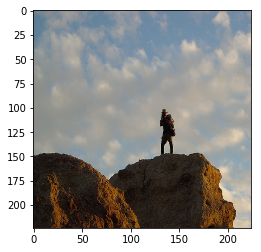

In [21]:
plt.imshow(image)

In [22]:
params = list(decoder.parameters()) 
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.001)

In [23]:
validation_loss_min = np.inf

In [24]:
train_losses=[]
validation_losses=[]

In [ ]:
f = open(log_file, 'w')
validation_f=open(val_log_file,'w')
i_step=0
print_every=100

for epoch in range(1, num_epochs+1):
    try:
        for images,captions in dataset.load_data(batch_size):
            images=torch.cat(images)


            # Move batch of images and captions to GPU if CUDA is available.
            images_gpu = images.to(device)
            captions_gpu = [caption.to(device) for caption in captions]
            captions_padded=nn.utils.rnn.pad_sequence(captions_gpu,batch_first=True)
            # Zero the gradients.
            decoder.zero_grad()
            encoder.zero_grad()

            # Pass the inputs through the CNN-RNN model.
            features = encoder(images_gpu)
            outputs = decoder(features, captions_gpu)

            # Calculate the batch loss.
    #         print("outputs.shape: ", outputs.shape)
            loss = criterion(outputs.contiguous().view(-1, vocab_size), captions_padded.view(-1))

            # Backward pass.
            loss.backward()

            # Update the parameters in the optimizer.
            optimizer.step()

            # Get training statistics.
            stats = 'Epoch [%d/%d], Step [%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, loss.item(), np.exp(loss.item()))

            # Print training statistics (on same line).
            print('\r' + stats, end="")


            # Print training statistics to file.
            f.write(stats + '\n')
            f.flush()

            # Print training statistics (on different line).
            if i_step % print_every == 0:
                print('\r' + stats)
            i_step=i_step+1
        train_losses.append(loss.item())
    except RuntimeError:
        print(captions,i_step)
        pass
    validation_loss=0
    validation_iter=1
    for images,captions in valid_dataset.load_data(batch_size):
        images=torch.cat(images)
        

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = [caption.to(device) for caption in captions]
        captions_padded=nn.utils.rnn.pad_sequence(captions,batch_first=True)
        with torch.no_grad():

            # Pass the inputs through the CNN-RNN model.
            features = encoder(images)
            outputs = decoder(features, captions)

        
        # Calculate the batch loss.
#         print("outputs.shape: ", outputs.shape)
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions_padded.view(-1))
        validation_loss=validation_loss+loss.item()
        validation_iter=validation_iter+1
        # Get training statistics.
    validation_loss = validation_loss/validation_iter
    validation_losses.append(validation_loss)
    stats = 'Epoch [%d/%d], Step [%d], Validation Loss: %.4f, Perplexity: %5.4f\n' % (epoch, num_epochs, validation_iter, validation_loss, np.exp(validation_loss))
    torch.save(decoder.state_dict(), os.path.join('models', 'decoder-%d.pkl' % epoch))
    torch.save(encoder.state_dict(), os.path.join('models', 'encoder-%d.pkl' % epoch))
    if validation_loss<validation_loss_min:
        print("\nmodel improved!")
        
        validation_loss_min=validation_loss
    else:
        print("\nnot improved yet!")
    # Print training statistics (on same line).
    print('\n' + stats, end="")


    # Print training statistics to file.
    validation_f.write(stats + '\n')
    validation_f.flush()

    # Print training statistics (on different line).



# Close the training log file.
f.close()
validation_f.close()

In [26]:
encoder.load_state_dict(torch.load("flickr_models/encoder-1.pkl",map_location="cpu"))
decoder.load_state_dict(torch.load("flickr_models/decoder-5.pkl",map_location="cpu"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [27]:
encoder.eval()
decoder.eval()

DecoderRNN(
  (word_embeddings): Embedding(2655, 4096)
  (lstm): LSTM(4096, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=2655, bias=True)
)

In [28]:
import matplotlib.pyplot as plt

In [33]:
 def sample(inputs):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        
        
        output = []
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = decoder.init_hidden(batch_size) # Get initial hidden state of the LSTM
    
        while True:
            lstm_out, hidden = decoder.lstm(inputs, hidden) # lstm_out shape : (1, 1, hidden_size)
            outputs = decoder.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
            outputs= nn.functional.softmax(outputs,dim=2)
            outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)
            _, max_indice = torch.max(outputs, dim=1) # predict the most likely next word, max_indice shape : (1)
            
            output.append(max_indice.cpu().numpy()[0].item()) # storing the word predicted
            
            if (max_indice == 0):
                # We predicted the <end> word, so there is no further prediction to do
                break
            
            ## Prepare to embed the last predicted word to be the new input of the lstm
            inputs = decoder.word_embeddings(max_indice) # inputs shape : (1, embed_size)
            inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size)
            
        return output

In [31]:
target_folder="flickr8k_images_outputs/test/"
count=0
for validation_image,validation_caption in test_dataset:
    encoder.eval()
    decoder.eval()
    validation_image=validation_image.to(device)
    validation_image=validation_image.view(1,3,224,224)
    actual_outputs=validation_caption.cpu().numpy().tolist()
    features=encoder(validation_image)
    outputs=sample(features.view(1,1,4096))
    output_words=[vocab.idx2word[output] for output in outputs]
    plt.figure()
    plt.imshow(validation_image[0].cpu().numpy().transpose((1,2,0)))
    plt.title(" ".join(output_words))
    plt.savefig("{}/{}.jpg".format(target_folder,count))
    count=count+1
#     if count>100:
#         break

NameError: name 'sample' is not defined

In [34]:
import cv2

work_image=cv2.imread("work.jpg")

work_image= cv2.resize(work_image,(224,224))

work_image= cv2.cvtColor(work_image,cv2.COLOR_BGR2RGB)

work_image=work_image/255

work_image_tensor= torch.from_numpy(work_image)

work_image_tensor.size()

work_image_tensor=work_image_tensor.permute((2,0,1))

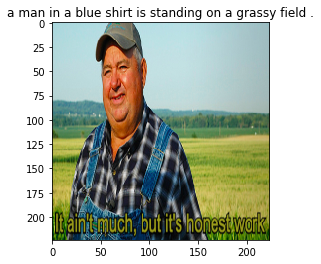

In [36]:
work_image_tensor.float().type()

encoder.eval()
decoder.eval()
validation_image=work_image_tensor.to(device)
validation_image=validation_image.view(1,3,224,224)
features=encoder(validation_image.float())
outputs=sample(features.view(1,1,4096))
output_words=[vocab.idx2word[output] for output in outputs]
plt.figure()
plt.imshow(validation_image[0].cpu().numpy().transpose((1,2,0)))
plt.title(" ".join(output_words[:-1]))
plt.savefig("work_result_en.jpg")#.format(target_folder,count))